In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import cv2
import time
from copy import deepcopy

# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [3]:
#extract telsa data
data = pd.read_csv("TSLA.csv")
data_np = data.to_numpy()
tesla_open = data_np[:,1]

print(len(tesla_open))

#print(tesla_open)

#extract google data
data = pd.read_csv("GOOGL.csv")
data_np = data.to_numpy()
google_open = data_np[:,1]

print(len(tesla_open))


#extract telsa data
data = pd.read_csv("DJI.csv")
data_np = data.to_numpy()
DJI_open = data_np[:,1]

print(len(tesla_open))


2227
2227
2227


## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [4]:
#scale the data
scaler = MinMaxScaler()
scaled_tesla = scaler.fit_transform(tesla_open.reshape(-1, 1))
scaled_google = scaler.fit_transform(google_open.reshape(-1, 1))
scaled_DJI = scaler.fit_transform(DJI_open.reshape(-1, 1))

#print(scaled_tesla)

d:\douglas_smith\anaconda3\envs\ee596\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
d:\douglas_smith\anaconda3\envs\ee596\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
d:\douglas_smith\anaconda3\envs\ee596\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [5]:
#learning rate
lr = 0.001
#number of traning steps
num_steps = 30
#number of batch_size
batch_size = 10
seq_len = 5

tesla_range = len(tesla_open) - seq_len#int(len(tesla_open)/seq_len)
tesla_sets = np.zeros([tesla_range, seq_len+1, 1])

#rearrange the data into a shape of [data_num, num_seq, features]
for i in range(tesla_range):    
    #split out the sequence
    chunk = scaled_tesla[i:i+seq_len+1]
    tesla_sets[i] = chunk

google_range = len(google_open) - seq_len
google_sets = np.zeros([google_range, seq_len+1, 1])

#rearrange the data into a shape of [data_num, num_seq, features]
for i in range(google_range):
    #split out the sequence
    chunk = scaled_google[i:i+seq_len+1]
    google_sets[i] = chunk

DJI_range = len(DJI_open) - seq_len  
DJI_sets = np.zeros([DJI_range, seq_len+1, 1])

#rearrange the data into a shape of [data_num, num_seq, features]
for i in range(DJI_range):
    #split out the sequence
    chunk = scaled_DJI[i:i+seq_len+1]
    DJI_sets[i] = chunk
    
#print(tesla_sets)
print(tesla_sets.shape)
print(google_sets.shape)
print(DJI_sets.shape)

#preserve the non-shuffled data for later testing
preserve_tesla = deepcopy(tesla_sets)
preserve_google = deepcopy(google_sets)
preserve_DJI = deepcopy(DJI_sets)

#shuffle on first axis
np.random.shuffle(tesla_sets)
np.random.shuffle(google_sets)
np.random.shuffle(DJI_sets)

#split into input and output
tesla_in = np.zeros([tesla_range, seq_len, 1])
tesla_out = np.zeros([tesla_range, 1])

for i in range(len(tesla_sets)):
    the_in = tesla_sets[i][0:seq_len]
    the_out = tesla_sets[i][seq_len]
    
    tesla_in[i] = the_in
    tesla_out[i] = the_out
    
    
#break things into batches
batch_length = int(len(tesla_in)/batch_size)
tesla_in_batched = np.zeros([batch_length, batch_size, seq_len ,1])
tesla_out_batched = np.zeros([batch_length, batch_size, 1])

for i in range(batch_length):
    step = i*batch_size
    
    chunk = tesla_in[step:step+batch_size]
    tesla_in_batched[i] = chunk
    
    chunk = tesla_out[step:step+batch_size]
    tesla_out_batched[i] = chunk
    

#redefine range
tesla_range = len(tesla_in_batched)

#split into training, validation, and testing by a 90%, 5%, 5%
train_range = int(tesla_range*0.9)
valid_range = int(tesla_range*0.05) + train_range
#test_range = the_range - train_range-valid_range

#tesla split
tesla_train_in = tesla_in_batched[0:train_range+1]
tesla_valid_in = tesla_in_batched[train_range+1:valid_range]
tesla_test_in = tesla_in_batched[valid_range:tesla_range]

tesla_train_out = tesla_out_batched[0:train_range+1]
tesla_valid_out = tesla_out_batched[train_range+1:valid_range]
tesla_test_out = tesla_out_batched[valid_range:tesla_range]

#print(train_range)
#print(valid_range)
#print(the_range)

print("in shapes")
print(tesla_train_in.shape)
print(tesla_valid_in.shape)
print(tesla_test_in.shape)

print("out shapes")
print(tesla_train_out.shape)
print(tesla_valid_out.shape)
print(tesla_test_out.shape)


#print(len(tesla_train_in))
#print(type(tesla_train_in[0][0][0][0]))
#print(type(tesla_train_out[0][0][0]))

#split into input and output
google_range = len(google_open) - seq_len
google_in = np.zeros([google_range, seq_len, 1])
google_out = np.zeros([google_range, 1])
for i in range(len(google_sets)):
    the_in = google_sets[i][0:seq_len]
    the_out = google_sets[i][seq_len]
    
    google_in[i] = the_in
    google_out[i] = the_out
    
    
#break things into batches
batch_length = int(len(google_in)/batch_size)
google_in_batched = np.zeros([batch_length, batch_size, seq_len ,1])
google_out_batched = np.zeros([batch_length, batch_size, 1])

for i in range(batch_length):
    step = i*batch_size
    
    chunk = google_in[step:step+batch_size]
    google_in_batched[i] = chunk
    
    chunk = google_out[step:step+batch_size]
    google_out_batched[i] = chunk
    

#redefine range
google_range = len(google_in_batched)

#split into training, validation, and testing by a 90%, 5%, 5%
train_range = int(google_range*0.9)
valid_range = int(google_range*0.05) + train_range
#test_range = the_range - train_range-valid_range

#google split
google_train_in = google_in_batched[0:train_range+1]
google_valid_in = google_in_batched[train_range+1:valid_range]
google_test_in = google_in_batched[valid_range:google_range]

google_train_out = google_out_batched[0:train_range+1]
google_valid_out = google_out_batched[train_range+1:valid_range]
google_test_out = google_out_batched[valid_range:google_range]

DJI_range = len(DJI_open) - seq_len
#split into input and output
DJI_in = np.zeros([DJI_range, seq_len, 1])
DJI_out = np.zeros([DJI_range, 1])

for i in range(len(DJI_sets)):
    the_in = DJI_sets[i][0:seq_len]
    the_out = DJI_sets[i][seq_len]
    
    DJI_in[i] = the_in
    DJI_out[i] = the_out
    
    
#break things into batches
batch_length = int(len(DJI_in)/batch_size)
DJI_in_batched = np.zeros([batch_length, batch_size, seq_len ,1])
DJI_out_batched = np.zeros([batch_length, batch_size, 1])

for i in range(batch_length):
    step = i*batch_size
    
    chunk = DJI_in[step:step+batch_size]
    DJI_in_batched[i] = chunk
    
    chunk = DJI_out[step:step+batch_size]
    DJI_out_batched[i] = chunk
    

#redefine range
DJI_range = len(DJI_in_batched)

#split into training, validation, and testing by a 90%, 5%, 5%
train_range = int(DJI_range*0.9)
valid_range = int(DJI_range*0.05) + train_range
#test_range = the_range - train_range-valid_range

#DJI split
DJI_train_in = DJI_in_batched[0:train_range+1]
DJI_valid_in = DJI_in_batched[train_range+1:valid_range]
DJI_test_in = DJI_in_batched[valid_range:DJI_range]

DJI_train_out = DJI_out_batched[0:train_range+1]
DJI_valid_out = DJI_out_batched[train_range+1:valid_range]
DJI_test_out = DJI_out_batched[valid_range:DJI_range]

(2222, 6, 1)
(3697, 6, 1)
(8631, 6, 1)
in shapes
(200, 10, 5, 1)
(10, 10, 5, 1)
(12, 10, 5, 1)
out shapes
(200, 10, 1)
(10, 10, 1)
(12, 10, 1)


# TensorFlow Model

In [6]:
tf.reset_default_graph()
#tf graph input
X = tf.placeholder(tf.float32,[None,seq_len,1],name='X')
Y = tf.placeholder(tf.float32,[None, 1],name='Y')

def RNN(x):   
    # create a BasicRNNCell
    rnn_cell = tf.nn.rnn_cell.LSTMCell(256)

    # 'state' is a tensor of shape [batch_size, cell_state_size]
    outputs, state = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32)#,initial_state=initial_state)
    
    #flatten to connect to fully connected
    full_in = flatten(outputs[:,seq_len-1,:])
    
    #fully connected layer
    full1 = tf.contrib.layers.fully_connected(inputs=full_in, num_outputs=1, activation_fn=None)
    
    return full1
#predicted labels
logits = RNN(X)

#define loss
#just_soft = tf.nn.softmax(logits=logits)
loss = tf.reduce_mean(tf.squared_difference(logits, Y),name='loss')

#define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

#compare the predicted labels with true labels
#correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(Y,1))

#compute the accuracy by taking average
#accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.


# Training

In [7]:
#Initialize the variables
init = tf.global_variables_initializer()

acc_list = []
steps = []

#Initialize the variables
def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session
sess = get_session()

#run the session
sess.run(init)

for i in range(num_steps):
    start_time = time.time()
    #epoch training
    acc_t = 0
    for j in range(len(tesla_train_in)):
        #fetch batch
        batch_x = tesla_train_in[j]
        batch_y = tesla_train_out[j]
        
        #run optimization
        sess.run(train_op, feed_dict={X:batch_x, Y:batch_y})

        acc_t += sess.run(loss, feed_dict={X:batch_x, Y:batch_y})

    acc_t = acc_t/len(tesla_train_in)
    if (i+1) % (num_steps/10) == 0:
        print("step "+str(i)+", Loss training= {:.3f}".format(acc_t))

    #epoch validation
    acc = 0
    for j in range(len(tesla_valid_in)):
        #fetch batch
        batch_x = tesla_valid_in[j]
        batch_y = tesla_valid_out[j]
        #run optimization
        acc += sess.run(loss, feed_dict={X:batch_x, Y:batch_y})

    acc = acc/len(tesla_valid_in)
    if (i+1) % (num_steps/10) == 0:
        print("step "+str(i)+", Loss Valid= {:.3f}".format(acc))
    acc_list.append(acc)
    steps.append(i)

    print("--- %s seconds ---" % (time.time() - start_time))

print("Training finished!")

acc = 0
for k in range(len(tesla_test_in)):
#fetch batch
    batch_x = tesla_test_in[k]
    batch_y = tesla_test_out[k]
    #run optimization
    acc += sess.run(loss, feed_dict={X:batch_x, Y:batch_y})



acc = acc/len(tesla_test_in)
print("Test Loss= {:.3f}".format(acc))

--- 3.7210195064544678 seconds ---
--- 1.6236095428466797 seconds ---
step 2, Loss training= 0.001
step 2, Loss Valid= 0.001
--- 1.5172874927520752 seconds ---
--- 1.508899450302124 seconds ---
--- 1.4151513576507568 seconds ---
step 5, Loss training= 0.001
step 5, Loss Valid= 0.001
--- 1.536348819732666 seconds ---
--- 1.550708293914795 seconds ---
--- 1.4569954872131348 seconds ---
step 8, Loss training= 0.001
step 8, Loss Valid= 0.001
--- 1.4269869327545166 seconds ---
--- 1.4197998046875 seconds ---
--- 1.4414775371551514 seconds ---
step 11, Loss training= 0.001
step 11, Loss Valid= 0.001
--- 1.4436631202697754 seconds ---
--- 1.554741382598877 seconds ---
--- 1.5715718269348145 seconds ---
step 14, Loss training= 0.000
step 14, Loss Valid= 0.001
--- 1.5784425735473633 seconds ---
--- 1.5591225624084473 seconds ---
--- 1.5473036766052246 seconds ---
step 17, Loss training= 0.000
step 17, Loss Valid= 0.001
--- 1.5485656261444092 seconds ---
--- 1.5597832202911377 seconds ---
--- 1.

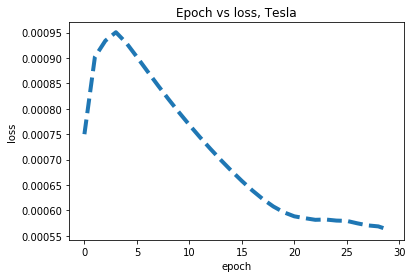

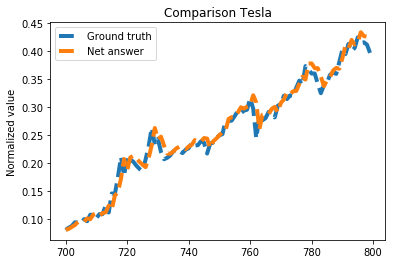

In [8]:
test_range = []
correct_guess = []
net_guess = []

#print the first images
for i in range(100):
    step = i + 700
    batch_x = [preserve_tesla[step][0:5]]
    #batch_y = tesla_test_out[0]
    #run optimization
    guesses = sess.run(logits, feed_dict={X:batch_x})

    test_range.append(step)
    correct_guess.append(preserve_tesla[step][5])
    net_guess.append(guesses[0])

plt.figure()
# plot epoch vs loss
plt.plot(steps,acc_list,'--',lw=4)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Epoch vs loss, Tesla')

plt.figure()
# plot stock range
plt.plot(test_range,correct_guess,'--',lw=4, label='Ground truth')
plt.plot(test_range,net_guess,'--',lw=4, label='Net answer')
plt.ylabel('Normalized value')
#plt.xlabel('epoch')
plt.title('Comparison Tesla')
plt.legend()

In [9]:
#Initialize the variables
init = tf.global_variables_initializer()

acc_list = []
steps = []

#run the session
sess.run(init)

for i in range(num_steps):
    start_time = time.time()
    #epoch training
    acc_t = 0
    for j in range(len(google_train_in)):
        #fetch batch
        batch_x = google_train_in[j]
        batch_y = google_train_out[j]
        #run optimization
        sess.run(train_op, feed_dict={X:batch_x, Y:batch_y})

        acc_t += sess.run(loss, feed_dict={X:batch_x, Y:batch_y})

    acc_t = acc_t/len(google_train_in)
    if (i+1) % (num_steps/10) == 0:
        print("step "+str(i)+", Loss training= {:.3f}".format(acc_t))

    #epoch validation
    acc = 0
    for j in range(len(google_valid_in)):
        #fetch batch
        batch_x = google_valid_in[j]
        batch_y = google_valid_out[j]
        #run optimization
        acc += sess.run(loss, feed_dict={X:batch_x, Y:batch_y})

    acc = acc/len(google_valid_in)
    if (i+1) % (num_steps/10) == 0:
        print("step "+str(i)+", Loss Valid= {:.3f}".format(acc))
    acc_list.append(acc)
    steps.append(i)

    print("--- %s seconds ---" % (time.time() - start_time))

print("Training finished!")

acc = 0
for k in range(len(google_test_in)):
#fetch batch
    batch_x = google_test_in[k]
    batch_y = google_test_out[k]
    #run optimization
    acc += sess.run(loss, feed_dict={X:batch_x, Y:batch_y})



acc = acc/len(google_test_in)
print("Test Loss= {:.3f}".format(acc))

--- 2.6470773220062256 seconds ---
--- 2.5960559844970703 seconds ---
step 2, Loss training= 0.000
step 2, Loss Valid= 0.000
--- 2.621987819671631 seconds ---
--- 2.684817314147949 seconds ---
--- 2.413543462753296 seconds ---
step 5, Loss training= 0.000
step 5, Loss Valid= 0.000
--- 2.348331928253174 seconds ---
--- 2.369311809539795 seconds ---
--- 2.577501058578491 seconds ---
step 8, Loss training= 0.000
step 8, Loss Valid= 0.000
--- 2.5643608570098877 seconds ---
--- 2.2968785762786865 seconds ---
--- 2.2501168251037598 seconds ---
step 11, Loss training= 0.000
step 11, Loss Valid= 0.000
--- 2.258871078491211 seconds ---
--- 2.2231662273406982 seconds ---
--- 2.402001142501831 seconds ---
step 14, Loss training= 0.000
step 14, Loss Valid= 0.000
--- 2.318779230117798 seconds ---
--- 2.3139331340789795 seconds ---
--- 2.4222002029418945 seconds ---
step 17, Loss training= 0.000
step 17, Loss Valid= 0.000
--- 2.5314090251922607 seconds ---
--- 2.54012393951416 seconds ---
--- 2.5712

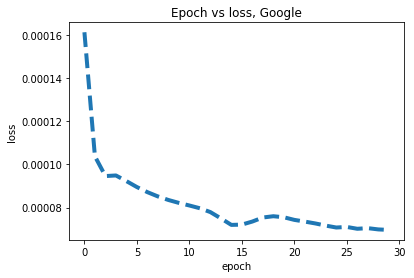

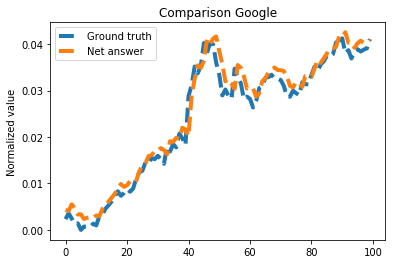

In [10]:
test_range = []
correct_guess = []
net_guess = []

#print the first images
for i in range(100):

    batch_x = [preserve_google[i][0:5]]
    #run optimization
    guesses = sess.run(logits, feed_dict={X:batch_x})

    test_range.append(i)
    correct_guess.append(preserve_google[i][5])
    net_guess.append(guesses[0])

    
plt.figure()
# plot epoch vs loss
plt.plot(steps,acc_list,'--',lw=4)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Epoch vs loss, Google')

plt.figure()
# plot stock range
plt.plot(test_range,correct_guess,'--',lw=4, label='Ground truth')
plt.plot(test_range,net_guess,'--',lw=4, label='Net answer')
plt.ylabel('Normalized value')
#plt.xlabel('epoch')
plt.title('Comparison Google')
plt.legend()

In [11]:
#Initialize the variables
init = tf.global_variables_initializer()

acc_list = []
steps = []

#run the session
sess.run(init)

for i in range(num_steps):
    start_time = time.time()
    #epoch training
    acc_t = 0
    for j in range(len(DJI_train_in)):
        #fetch batch
        batch_x = DJI_train_in[j]
        batch_y = DJI_train_out[j]
        #run optimization
        sess.run(train_op, feed_dict={X:batch_x, Y:batch_y})

        acc_t += sess.run(loss, feed_dict={X:batch_x, Y:batch_y})

    acc_t = acc_t/len(DJI_train_in)
    if (i+1) % (num_steps/10) == 0:
        print("step "+str(i)+", Loss training= {:.3f}".format(acc_t))

    #epoch validation
    acc = 0
    for j in range(len(DJI_valid_in)):
        #fetch batch
        batch_x = DJI_valid_in[j]
        batch_y = DJI_valid_out[j]
        #run optimization
        acc += sess.run(loss, feed_dict={X:batch_x, Y:batch_y})

    acc = acc/len(DJI_valid_in)
    if (i+1) % (num_steps/10) == 0:
        print("step "+str(i)+", Loss Valid= {:.3f}".format(acc))
    acc_list.append(acc)
    steps.append(i)

    print("--- %s seconds ---" % (time.time() - start_time))

print("Training finished!")

acc = 0
for k in range(len(DJI_test_in)):
#fetch batch
    batch_x = DJI_test_in[k]
    batch_y = DJI_test_out[k]
    #run optimization
    acc += sess.run(loss, feed_dict={X:batch_x, Y:batch_y})



acc = acc/len(DJI_test_in)
print("Test Loss= {:.3f}".format(acc))

--- 6.077123641967773 seconds ---
--- 6.156198501586914 seconds ---
step 2, Loss training= 0.000
step 2, Loss Valid= 0.000
--- 5.609090805053711 seconds ---
--- 5.582674264907837 seconds ---
--- 6.001462936401367 seconds ---
step 5, Loss training= 0.000
step 5, Loss Valid= 0.000
--- 5.838452339172363 seconds ---
--- 5.929742813110352 seconds ---
--- 5.368238687515259 seconds ---
step 8, Loss training= 0.000
step 8, Loss Valid= 0.000
--- 5.561945915222168 seconds ---
--- 5.691397190093994 seconds ---
--- 5.825129985809326 seconds ---
step 11, Loss training= 0.000
step 11, Loss Valid= 0.000
--- 5.790711164474487 seconds ---
--- 6.003780841827393 seconds ---
--- 6.0307111740112305 seconds ---
step 14, Loss training= 0.000
step 14, Loss Valid= 0.000
--- 5.681148052215576 seconds ---
--- 5.895706415176392 seconds ---
--- 5.614136695861816 seconds ---
step 17, Loss training= 0.000
step 17, Loss Valid= 0.000
--- 5.579944133758545 seconds ---
--- 5.605059623718262 seconds ---
--- 5.36371350288

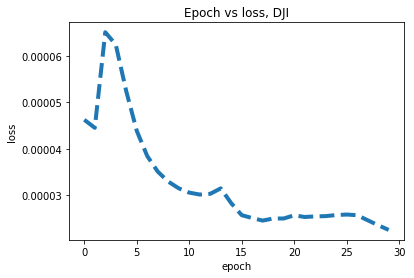

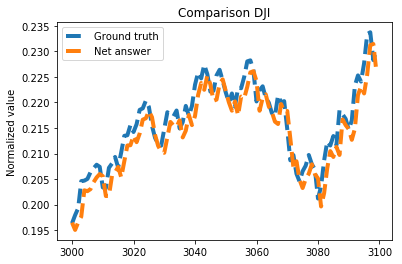

In [12]:
test_range = []
correct_guess = []
net_guess = []

#print the first images
for i in range(100):
    step = i + 3000
    batch_x = [preserve_DJI[step][0:5]]
    #batch_y = DJI_test_out[0]
    #run optimization
    guesses = sess.run(logits, feed_dict={X:batch_x})

    test_range.append(step)
    correct_guess.append(preserve_DJI[step][5])
    net_guess.append(guesses[0])

plt.figure()
# plot epoch vs loss
plt.plot(steps,acc_list,'--',lw=4)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Epoch vs loss, DJI')

plt.figure()
# plot stock range
plt.plot(test_range,correct_guess,'--',lw=4, label='Ground truth')
plt.plot(test_range,net_guess,'--',lw=4, label='Net answer')
plt.ylabel('Normalized value')
#plt.xlabel('epoch')
plt.title('Comparison DJI')
plt.legend()

# Testing

Overall the results look good. For all three datasets the trained model is able to track the fluxuations of the stock fairly well. 